In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

2025-07-16 17:14:15.996970: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 17:14:16.033744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-16 17:14:16.033770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-16 17:14:16.034707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 17:14:16.040825: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# We need the previously trained model? Where is it?
CNN_model = tf.keras.models.load_model('../../Spring_2024/Bayes_for_comps/TS_bayes_implementation_for_TN/models/trained_gmp_model_dense_32_new.h5')

2025-07-16 17:14:17.902091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0


In [3]:
CNN_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                           

In [4]:
# We will only use the part of the model used for featrue extraction

feat_ext_input = CNN_model.input

feat_ext_output = CNN_model.layers[-4].output

feature_extractor_model = tf.keras.models.Model(inputs = feat_ext_input, outputs = feat_ext_output)

In [5]:
feature_extractor_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                             

In [6]:
# We might need to give attention to how the layer weights need to be trained, I think first we freeze everything, and then we unfreeze some, let's look at this in the CNN-LSTM work that was previously done.

In [7]:
# Over here let's just focus on the architecture of the cnn seq2seq model

In [8]:
# Shape of the input would be [None, 13, None, None, 3] - notice that the first dimension is for the time component

In [9]:
# I think we wrap this in a time distributed layer? and then pass it throgh a LSTM layer to respect the time dimension. This should give us our encoder part of the model. For now, we will not include teacher forcing, but let's keep in mind this is something we can do to improve model performance.

In [10]:
# Encoder model

In [11]:
encoder_input = tf.keras.layers.Input(shape = (None, None, None, 3)) # The first None over here represent the time dimension, let's leave it as None instead of 13 for now as it is more generic

# pass the model through a time distributed layer
td_model = tf.keras.layers.TimeDistributed(feature_extractor_model)

td_out = td_model(encoder_input)


In [12]:
model_till_now = tf.keras.models.Model(inputs = encoder_input, outputs = td_out)

In [13]:
model_till_now.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 time_distributed (TimeDist  (None, None, 32)          71808     
 ributed)                                                        
                                                                 
Total params: 71808 (280.50 KB)
Trainable params: 43168 (168.62 KB)
Non-trainable params: 28640 (111.88 KB)
_________________________________________________________________


In [14]:
# just to make sure the time dimension is correctly accounted for, let's do the following

In [15]:
test_encoder_input = tf.keras.layers.Input(shape = (13, None, None, 3)) 
test_td_model = tf.keras.layers.TimeDistributed(feature_extractor_model)
test_td_out = test_td_model(test_encoder_input)

test_model = tf.keras.models.Model(inputs = test_encoder_input, outputs = test_td_out)

test_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13, None, None,   0         
                              3)]                                
                                                                 
 time_distributed_1 (TimeDi  (None, 13, 32)            71808     
 stributed)                                                      
                                                                 
Total params: 71808 (280.50 KB)
Trainable params: 43168 (168.62 KB)
Non-trainable params: 28640 (111.88 KB)
_________________________________________________________________


In [16]:
# Okay, now pass an LSTM layer here, without return sequences, as the context vector is probably enough for our decoder?

In [17]:
lstm_layer = tf.keras.layers.LSTM(64, activation = "relu", return_state = True, return_sequences = False)

In [18]:
encoder_outputs, state_h, state_c = lstm_layer(td_out)

In [19]:
encoder_model = tf.keras.models.Model(inputs = encoder_input, outputs = encoder_outputs)

In [20]:
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 time_distributed (TimeDist  (None, None, 32)          71808     
 ributed)                                                        
                                                                 
 lstm (LSTM)                 [(None, 64),              24832     
                              (None, 64),                        
                              (None, 64)]                        
                                                                 
Total params: 96640 (377.50 KB)
Trainable params: 68000 (265.62 KB)
Non-trainable params: 28640 (111.88 KB)
_________________________________________________________________


In [21]:
# Okay, now for the decoder part of the model

# We need to repeat the context vector 7 times as the inputs into the decoder

decoder_inp = tf.keras.layers.RepeatVector(7)(encoder_outputs)

In [22]:
decoder_inp.shape

TensorShape([None, 7, 64])

In [23]:
# Have an LSTM here on top of this for the output - and I think here we do need the return sequences to True
decoder_lstm = tf.keras.layers.LSTM(64, return_sequences = True, activation = 'relu')

decoder_out = decoder_lstm(decoder_inp, initial_state = [state_h, state_c])

# And now a dense layer for this - with a time distributed layer - but can do a just Dense too

dense_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation = 'relu'))

dense_out = dense_layer(decoder_out)

In [24]:
model_till_now = tf.keras.models.Model(inputs = encoder_input, outputs = dense_out)

In [25]:
model_till_now.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, None,    0         []                            
                             3)]                                                                  
                                                                                                  
 time_distributed (TimeDist  (None, None, 32)             71808     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 24832     ['time_distributed[0][0]']    
                              (None, 64),                                                   

In [26]:
# Put all these together and write out the full model for the future

In [27]:
input_time = 13
feature_size = 32
output_time = 7

# Encoder
# define encoder input
encoder_input = tf.keras.layers.Input(shape = (input_time, None, None, 3)) 

# pass the feature extractor model through a TD layer
td_model = tf.keras.layers.TimeDistributed(feature_extractor_model)

td_out = td_model(encoder_input)

# add an lstm to process the input sequence
lstm_layer = tf.keras.layers.LSTM(64, activation = "relu", return_state = True, return_sequences = False)

encoder_outputs, state_h, state_c = lstm_layer(td_out)

# Decoder

# repeat the context vector 7 times
decoder_inp = tf.keras.layers.RepeatVector(output_time)(encoder_outputs)

# define an LSTM for the output sequence
decoder_lstm = tf.keras.layers.LSTM(64, return_sequences = True, activation = 'relu')

decoder_out = decoder_lstm(decoder_inp, initial_state = [state_h, state_c])

# TD dense layer to generate the output sequnces
dense_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(feature_size, activation = 'relu'))

dense_out = dense_layer(decoder_out)

# define the model
CNN_seq2seq_model = tf.keras.models.Model(inputs = encoder_input, outputs = dense_out)

In [28]:
CNN_seq2seq_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed_3 (TimeDi  (None, 13, 32)               71808     ['input_3[0][0]']             
 stributed)                                                                                       
                                                                                                  
 lstm_2 (LSTM)               [(None, 64),                 24832     ['time_distributed_3[0][0]']  
                              (None, 64),                                                   

In [29]:
# Before moving to preprocessing - let's tackle the number of params in each layer

In [30]:
# now the initial params coming from the previous model - let's hold on to this for a moment.
71841 - 33 # we only removed the last dense layer
# 71808

71808

In [31]:
# now for the LSTM - we have 4 types of gates, hence we devide this number by 4 to find the number of params in one
24832/4     

6208.0

In [32]:
# Okay, where is this 6208 coming from? we have 64 dimensions in the hidden neurons for the LSTM, and 32 input features

# ht = f(WXt + Uh(t-1) + b)

# b - 64*1
# W - 64*32
# U - 64*64

In [33]:
64*64 + 64*32 + 64

6208

In [34]:
# now for the LSTM in the decoder
33024/4

8256.0

In [35]:
# from context vector, we have 64 input features
encoder_outputs.shape

TensorShape([None, 64])

In [36]:
# Therefore 

# b - 64*1
# W - 64*64
# U - 64*64

In [37]:
64*64 + 64*64 + 64

8256

In [38]:
# and then for the dense layer, we have all these weights shared across the 7 time periods, and also we have the bias neurons
64*32 + 32

2080

In [39]:
# Let's not get into the CNN for now as we need to know kernel sizes and padding and all that, we might have even worked this out some place else. Also notice that we may need to look into setting the weights of the CNN to freezing and unfreezing during the model training.

In [40]:
# Also during the previous implementation of the CNN LSTM, we added back the Dense layers after the global max pooling layer, so let's do the same here to be consistent. Let's define everyhting from new.

In [41]:
# Define this reduced model

output_reduced = CNN_model.layers[-11].output

In [42]:
reduced_model = tf.keras.models.Model(inputs = CNN_model.input, outputs = output_reduced)

In [43]:
reduced_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                           

In [44]:
# okay, now need to add back the dropout, the dense and activation

# add dropout
added_dropout = tf.keras.layers.Dropout(0.5, name = "New_dropout_0")(CNN_model.layers[-11].output)

# add global max pooling
added_flatten = tf.keras.layers.GlobalMaxPooling2D()(added_dropout)

# add dense
added_dense = tf.keras.layers.Dense(64, name = "New_Dense_0")(added_flatten)

# add activation
added_Act = tf.keras.layers.Activation('relu', name = "New_Activation_0")(added_dense)

# add dropout
added_dropout2 = tf.keras.layers.Dropout(0.5, name = "New_dropout_1")(added_Act)

# # add another dense
added_dense_1 = tf.keras.layers.Dense(32, name = "New_Dense_1")(added_dropout2)

# # add activation
added_Act_1 = tf.keras.layers.Activation('relu', name = "New_Activation_1")(added_dense_1)

new_model = tf.keras.models.Model(CNN_model.input, added_Act_1)

In [45]:
new_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                           

In [46]:
# 43168-2080 = 41088

In [47]:
# now pass this throuhg the TD layer and add the other layers to this, and we will have the encoder and the decoder

In [48]:
input_time = 13
feature_size = 32
output_time = 7

# Encoder
# define encoder input
encoder_input = tf.keras.layers.Input(shape = (input_time, None, None, 3)) 

# pass the feature extractor model through a TD layer
td_model = tf.keras.layers.TimeDistributed(new_model)

td_out = td_model(encoder_input)

# add an lstm to process the input sequence
lstm_layer = tf.keras.layers.LSTM(64, activation = "relu", return_state = True, return_sequences = False)

encoder_outputs, state_h, state_c = lstm_layer(td_out)

# Decoder

# repeat the context vector 7 times
decoder_inp = tf.keras.layers.RepeatVector(output_time)(encoder_outputs)

# define an LSTM for the output sequence
decoder_lstm = tf.keras.layers.LSTM(64, return_sequences = True, activation = 'relu')

decoder_out = decoder_lstm(decoder_inp, initial_state = [state_h, state_c])

# TD dense layer to generate the output sequnces
dense_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(feature_size, activation = 'relu'))

dense_out = dense_layer(decoder_out)

# define the model
CNN_seq2seq_model = tf.keras.models.Model(inputs = encoder_input, outputs = dense_out)

In [49]:
CNN_seq2seq_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed_5 (TimeDi  (None, 13, 32)               71808     ['input_4[0][0]']             
 stributed)                                                                                       
                                                                                                  
 lstm_4 (LSTM)               [(None, 64),                 24832     ['time_distributed_5[0][0]']  
                              (None, 64),                                                   

In [50]:
# now, we can freeze the laeyr weights of the CNN model (the CNN layers at least)

# freeze the layers
for layer in CNN_model.layers:
    layer.trainable = False

In [51]:
# verify the required weights are frozen?
CNN_seq2seq_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed_5 (TimeDi  (None, 13, 32)               71808     ['input_4[0][0]']             
 stributed)                                                                                       
                                                                                                  
 lstm_4 (LSTM)               [(None, 64),                 24832     ['time_distributed_5[0][0]']  
                              (None, 64),                                                   

In [52]:
# 36928 + 18496 + 9248 + 896 = 65568
# The weights indeed match

In [53]:
# And when unfreezing, we can do this
CNN_model.trainable = True

set_trainable = False

for layer in CNN_model.layers:
    if layer.name == 'conv2d_3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [54]:
CNN_seq2seq_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed_5 (TimeDi  (None, 13, 32)               71808     ['input_4[0][0]']             
 stributed)                                                                                       
                                                                                                  
 lstm_4 (LSTM)               [(None, 64),                 24832     ['time_distributed_5[0][0]']  
                              (None, 64),                                                   

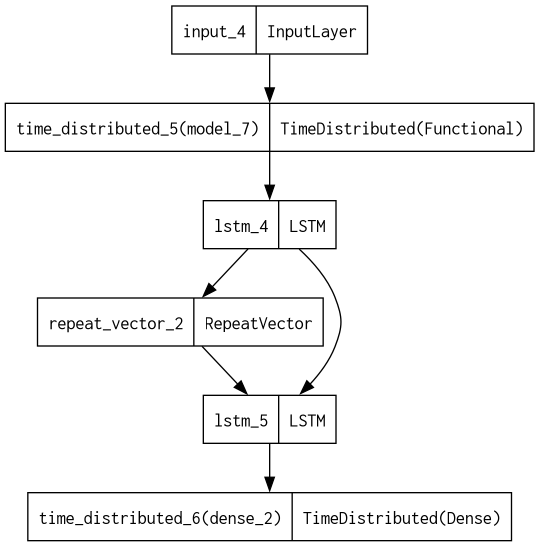

In [56]:
tf.keras.utils.plot_model(CNN_seq2seq_model)

In [57]:
# 18496 + 9248 + 896 = 28640
# weights match

Base model for comparison in stage 2

In [58]:
# Below we will write the model for base model for comparing our work in stage 2. The idea is to use the sub-images as inputs, and densities for each timestep as outputs. I think this can also be considered a CNN-LSTM model that we can fit for our data. Let's do this mode below.

In [59]:
# We use our previous fine-tuned CNN model for the encoder part. We will write the reduced model, add back the non-conv layers, then pass this model through a TD layer, have a context vector, pass it though a RepeatVector layer, as the input to the decoder model, and then have another LSTM followed by a dense layer model to give us the outputs

In [60]:
# Define this reduced model

output_reduced = CNN_model.layers[-11].output

In [61]:
reduced_model = tf.keras.models.Model(inputs = CNN_model.input, outputs = output_reduced)

In [62]:
reduced_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                           

In [63]:
# okay, now need to add back the dropout, the dense and activation

# add dropout
added_dropout = tf.keras.layers.Dropout(0.5, name = "New_dropout_0")(CNN_model.layers[-11].output)

# add global max pooling
added_flatten = tf.keras.layers.GlobalMaxPooling2D()(added_dropout)

# add dense
added_dense = tf.keras.layers.Dense(64, name = "New_Dense_0")(added_flatten)

# add activation
added_Act = tf.keras.layers.Activation('relu', name = "New_Activation_0")(added_dense)

# add dropout
added_dropout2 = tf.keras.layers.Dropout(0.5, name = "New_dropout_1")(added_Act)

# # add another dense
added_dense_1 = tf.keras.layers.Dense(32, name = "New_Dense_1")(added_dropout2)

# # add activation
added_Act_1 = tf.keras.layers.Activation('relu', name = "New_Activation_1")(added_dense_1)

new_model = tf.keras.models.Model(CNN_model.input, added_Act_1)

In [64]:
new_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                          

In [65]:
36928 + 4160 + 2080

43168

In [66]:
# Okay, now define our model
input_time = 13
output_time = 7
feature_size = 1
# Encoder part

# input
Encoder_input = tf.keras.layers.Input(shape = [input_time, None, None, 3])

# pass model through TD layer
TD_model = tf.keras.layers.TimeDistributed(new_model)

TD_out = TD_model(Encoder_input)

# pass this through a sequence model to adress the sequential nature of the input image sequence
lstm_layer = tf.keras.layers.LSTM(64, return_sequences = False, return_state = True)

lstm_out, state_h, state_c = lstm_layer(TD_out)

# Decoder part

# repeat the context vector
decoder_inp = tf.keras.layers.RepeatVector(output_time)(lstm_out)

# Add an LSTM layer for the decoder
decoder_LSTM = tf.keras.layers.LSTM(64, return_sequences = True, return_state = False)

lstm_out = decoder_LSTM(decoder_inp, initial_state = [state_h, state_c])

# add a dense layer to get the targets
dense_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(feature_size, activation = 'relu'))

pred_head = dense_layer(lstm_out)

In [67]:
base_model = tf.keras.models.Model(inputs = Encoder_input, outputs = pred_head)

In [68]:
base_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed_7 (TimeDi  (None, 13, 32)               71808     ['input_5[0][0]']             
 stributed)                                                                                       
                                                                                                  
 lstm_6 (LSTM)               [(None, 64),                 24832     ['time_distributed_7[0][0]']  
                              (None, 64),                                                  

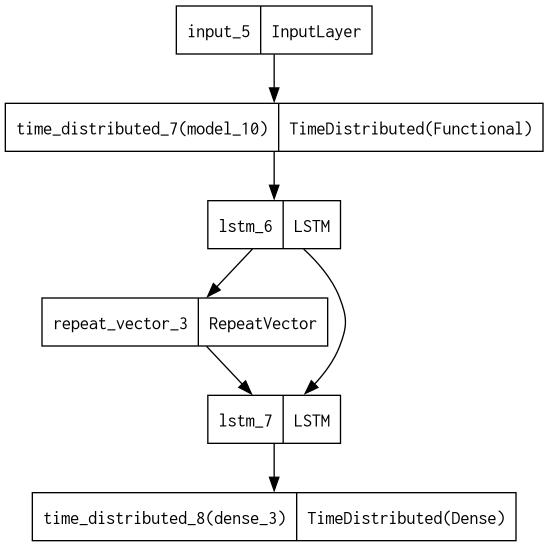

In [69]:
tf.keras.utils.plot_model(base_model)

In [70]:
# might need to add another dimension to the (None, 7) shape we have for the targets

In [71]:
# Need to also take care of freezing and unfreezing weights during model training